# Stock Price Prediction Using GRU

This notebook explores the use of the `Gated Recurrent Unit (GRU)` neural networks to predict stock prices by leveraging historical financial data. It incorporates advanced preprocessing techniques, including feature normalization, and sliding window datasets, to enhance predictive accuracy. The workflow also includes model evaluation metrics, visualization of predictions, and confidence interval plotting to provide comprehensive insights into the forecasted trends.

## Install Libraries

In [ ]:
!pip install -r requirements.txt

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tabulate import tabulate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout


## Data

### Select Stock
We select the `Ticker` sysmbol for the share we aim to forecast and select the `start_date` of our data. The `end_date` is the current date.

In [36]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Ticker: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Ticker: TSLA
Start Date: 2015-01-01
End Date: 2024-12-19


### Download Data
We now download the data we need for training our forecasting model. We select the interval of our data depending on the interval we want to forecast e.g. daily, weekly, monthly e.t.c.

In [37]:
# df = yf.download(stock_symbol, start=start_date, end=end_date, interval='1wk')
df = yf.download(stock_symbol, start=start_date, end=end_date, interval='1mo')
# df = yf.download(stock_symbol, start=start_date, end=end_date, interval='1d')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-01,13.573333,13.573333,14.883333,12.333333,14.858000,1353076500
2015-02-01,13.556000,13.556000,15.032000,12.885333,13.598000,1600762500
2015-03-01,12.584667,12.584667,13.746000,12.093333,13.513333,1844851500
2015-04-01,15.070000,15.070000,15.916667,12.403333,12.580000,1484176500
2015-05-01,16.719999,16.719999,16.858000,14.683333,15.329333,1336917000


### Select Columns
We select the columns we are interested in from the dataset, `['Open', 'Close', 'Volume', 'Low', 'High']`, set the Date as the index and insure that it is of `datetime` format.

In [38]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2015-01-01,14.858000,13.573333,1353076500,12.333333,14.883333
2015-02-01,13.598000,13.556000,1600762500,12.885333,15.032000
2015-03-01,13.513333,12.584667,1844851500,12.093333,13.746000
2015-04-01,12.580000,15.070000,1484176500,12.403333,15.916667
2015-05-01,15.329333,16.719999,1336917000,14.683333,16.858000


### Display Stock Chart
We display the Closing price of the Stock 

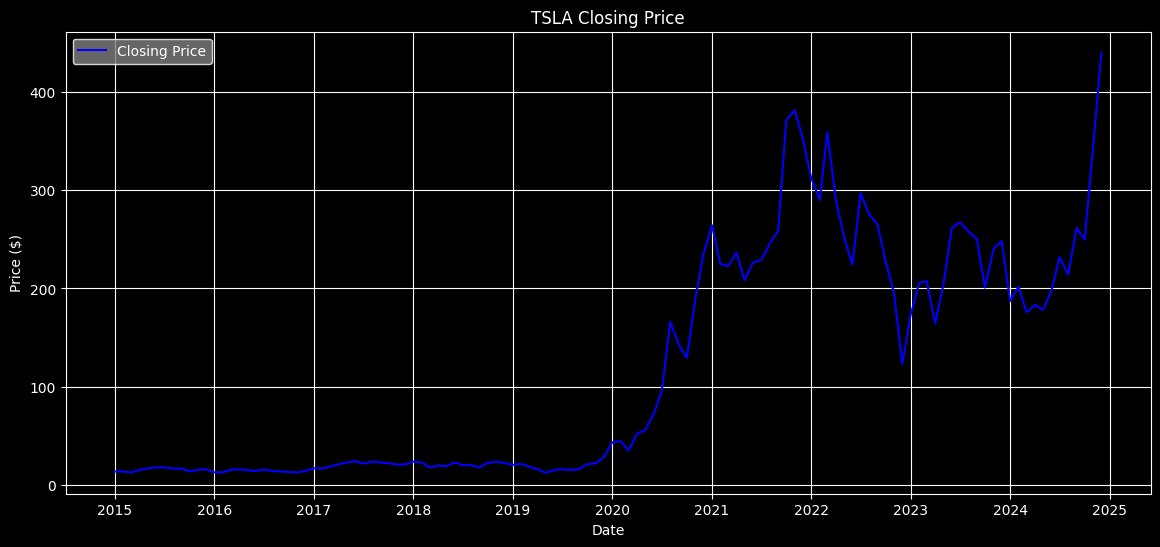

In [39]:
# Set dark mode for the plot
plt.style.use('dark_background')  # Use dark background style

# Plot the closing price
plt.figure(figsize=(14, 6))

plt.plot(df['Close'], label='Closing Price', color='blue')  # Change color for visibility

# Add title, labels, and legend with appropriate colors for dark mode
plt.title(f'{stock_symbol} Closing Price', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Price ($)', color='white')
plt.legend(facecolor='gray', edgecolor='white', labelcolor='white')
plt.grid()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart.png', dpi=300)

# Show the plot
plt.show()


## Data Preprocessing

### Data Normalization
This cell normalizes the selected stock features to a scale between 0 and 1 using MinMaxScaler to prepare the data for model training.

In [40]:
# Normalize the data (scale between 0 and 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Open', 'Volume', 'Low', 'High']])  # Use all features for prediction

### Sliding Window Dataset Creation and Data Preparation  

This section implements a `sliding window` approach to structure the dataset for time series prediction, where each window contains `30 timesteps of historical data` used to predict the next day's values. The choice of a 30-timesteps window ensures sufficient context for capturing trends and patterns. The data is reshaped to align with the GRU model's input format, accommodating the five features (Close, Open, Volume, Low, High). 

In [41]:

# Function to create sliding window dataset
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])  # Append the entire window of all features
        y.append(data[i + window_size])  # Append the target window for the next day (all features)
    return np.array(X), np.array(y)

# Define sliding window size
window_size = 30  # 30 timesteps of data to predict the next day's data

# Prepare data
X, y = create_sliding_window(scaled_data, window_size)

# Reshape X to (samples, timesteps, features) for GRU
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # X.shape[2] will be 5 because we have 5 features

### Data Split
The dataset is then split into training and testing sets, with `80% used for training` to ensure the model has ample data for learning while reserving `20% for validation` and evaluation.

In [42]:

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 72, Testing Samples: 18


## Model Training

### Model Architecture and Compilation

In this section, a **GRU (Gated Recurrent Unit)** model is built to predict multiple features `(Open, Close, Volume, Low, High)` of the stock data. The model starts with a GRU layer that processes sequential data with `50 units` and uses the `tanh` activation function to introduce non-linearity. The `return_sequences=False` ensures that the output of the GRU layer is a single vector, not a sequence, as the model predicts the values for all features at once. A `Dropout` layer with a rate of 0.3 is included to reduce overfitting by randomly setting a fraction of input units to zero during training. The output layer is a `Dense` layer with 5 units, corresponding to the five features we aim to predict.

The model is compiled using the `Adam optimizer` for efficient gradient-based optimization and `Mean Squared Error (MSE)` as the loss function to minimize prediction errors. Additionally, `Mean Absolute Error (MAE)` is tracked as a metric to evaluate the model’s performance during training.

In [43]:
# Build the GRU model to predict all features
model = Sequential([
    GRU(50, activation='tanh', return_sequences=False, input_shape=(window_size, 5)),  # Input shape for 5 features
    Dropout(0.3),  # Regularization to prevent overfitting
    Dense(5)  # Output layer for predicting 5 features (Open, Close, Volume, Low, High)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\GRU_stock_price_forecasting\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Fit the Model

In [44]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - loss: 0.2140 - mae: 0.3275 - val_loss: 0.2745 - val_mae: 0.4615
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1768 - mae: 0.3026 - val_loss: 0.2091 - val_mae: 0.4002
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1308 - mae: 0.2572 - val_loss: 0.1555 - val_mae: 0.3415
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0923 - mae: 0.2206 - val_loss: 0.1092 - val_mae: 0.2808
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0798 - mae: 0.2150 - val_loss: 0.0719 - val_mae: 0.2193
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0616 - mae: 0.1911 - val_loss: 0.0452 - val_mae: 0.1613
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0517 - mae: 0.1784 - val_loss: 0.0278 - val_mae: 0.1170
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0424 - mae: 0.1676 - val_loss: 0.0201 - val_mae: 0.1001
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0484 - ma

### Training Results

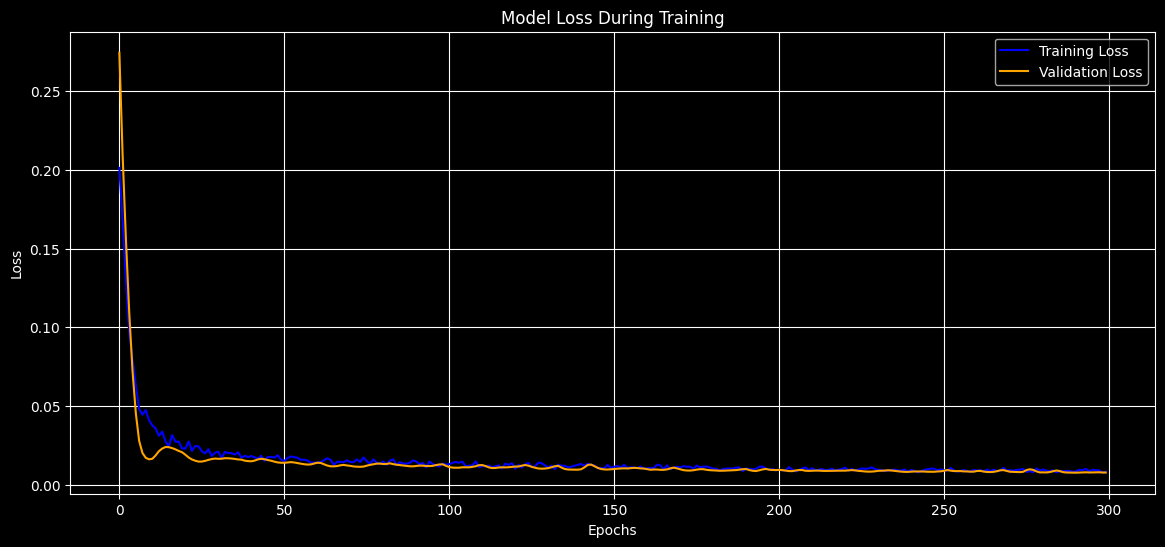

In [45]:
# Plot model loss during training
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Model Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(f'{stock_symbol}_model_loss.png')
plt.show()

## Model Evaluation

### Error Metrics
In this section, we evaluate the performance of our trained model on the test set. We make predictions for the entire test set, then inverse scale the predicted and actual values to obtain the original stock prices. For each of the five features (Open, Close, Volume, Low, High), we compute three key error metrics: `Mean Absolute Error (MAE)`, `Mean Squared Error (MSE)`, and the `R² Score`. These metrics provide insight into the accuracy of the predictions and how well the model is performing for each feature.

In [46]:
# Predictions for the entire test set
test_predictions = model.predict(X_test)

# Inverse scale the predictions (for multiple features)
test_predictions_actual = scaler.inverse_transform(test_predictions)  # Shape: (samples, 5)

# Inverse scale the actual values (y_test) for the features
y_test_actual = scaler.inverse_transform(y_test)  # Shape: (samples, 5)

# Features of interest
features = ['Open', 'Close', 'Volume', 'Low', 'High']

# Initialize a list to store the results
results = []

# Iterate through each feature
for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_actual[:, i], test_predictions_actual[:, i])
    mse = mean_squared_error(y_test_actual[:, i], test_predictions_actual[:, i])
    r2 = r2_score(y_test_actual[:, i], test_predictions_actual[:, i])
    # Append results to the list
    results.append([feature, mae, mse, r2])

# Display the results using tabulate
headers = ['Feature', 'Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R² Score']
print(tabulate(results, headers=headers, tablefmt="rounded_grid"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
╭───────────┬─────────────────────────────┬────────────────────────────┬────────────╮
│ Feature   │   Mean Absolute Error (MAE) │   Mean Squared Error (MSE) │   R² Score │
├───────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ Open      │                32.8234      │             2313.12        │   0.424669 │
├───────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ Close     │                10.642       │              211.392       │   0.886607 │
├───────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ Volume    │                 3.98857e+08 │                2.36673e+17 │  -0.178101 │
├───────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ Low       │                24.0988      │              949.857       │   0.537887 │
├───────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ High      │  

### Model Testing with Confidence Interval

In this section, we focus on evaluating the performance of the model specifically for the `Closing Prices`. The actual and predicted closing prices are extracted and plotted. Additionally, we calculate the `95% confidence interval` around the predicted closing prices, assuming the standard deviation is known. This confidence interval provides a range in which we can expect the actual values to fall, reflecting the uncertainty in the predictions. The plot displays both the actual and predicted closing prices, along with the shaded area representing the confidence interval, allowing us to visually assess the model's performance.


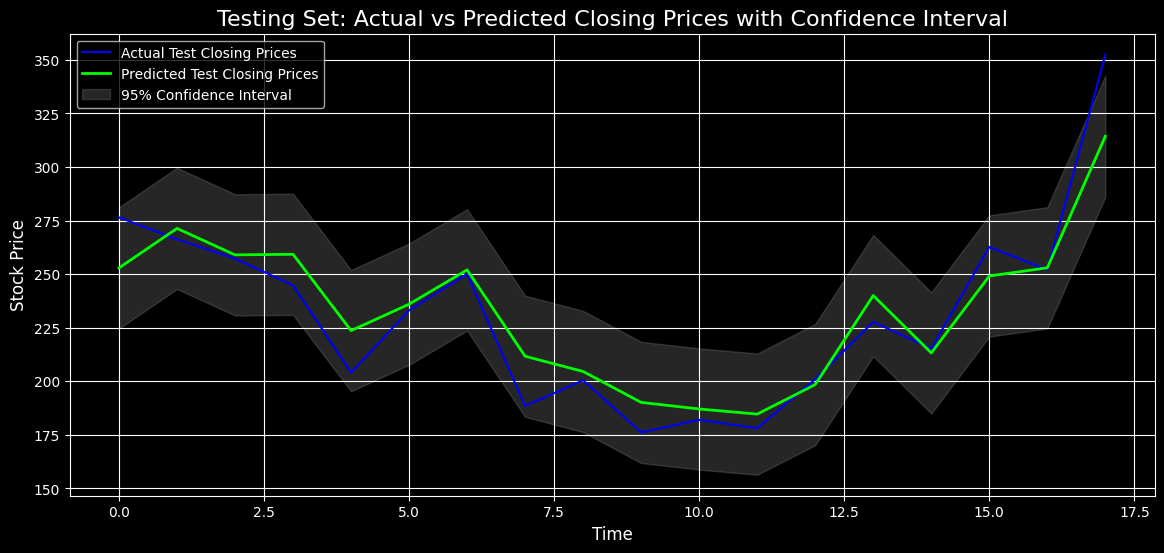

In [47]:
# Extract only the 'Close' column for actual and predicted prices
y_test_actual_close = y_test_actual[:, features.index('Close')]  # Actual closing prices
test_predictions_close = test_predictions_actual[:, features.index('Close')]  # Predicted closing prices

# Calculate 95% confidence interval
# Assuming standard deviation is known
std_dev = np.std(test_predictions_close - y_test_actual_close)
confidence_upper = test_predictions_close + 1.96 * std_dev
confidence_lower = test_predictions_close - 1.96 * std_dev

# Plot the testing predictions for the 'Close' prices with confidence interval
plt.figure(figsize=(14, 6))

# Plot actual and predicted prices
plt.plot(range(len(y_test_actual_close)), y_test_actual_close, label="Actual Test Closing Prices", color='blue')
plt.plot(range(len(test_predictions_close)), test_predictions_close, label="Predicted Test Closing Prices", color='lime', linewidth=2)

# Add confidence interval shading
plt.fill_between(range(len(test_predictions_close)), confidence_lower, confidence_upper, color='gray', alpha=0.3, label='95% Confidence Interval')

# Add title, labels, and legend
plt.title("Testing Set: Actual vs Predicted Closing Prices with Confidence Interval", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Price", fontsize=12)
plt.legend()

# Display grid and show the plot
plt.grid(True)
plt.savefig(f'{stock_symbol}_test_predictions_close.png')
plt.show()


## Forecast

### Future Stock Price Prediction and Confidence Interval

This section predicts the stock prices for the next `30 timesteps` using the trained GRU model. The prediction starts by using the last `window_size` days of the dataset as the initial input for the model. The model then generates predictions for the subsequent days, and the sliding window approach is employed to update the input with each new prediction. After obtaining the predicted values for all features, the results are inverse-transformed to obtain actual prices, specifically focusing on the `Closing Price`. 

Additionally, a `95% confidence interval` is calculated for these future predictions, providing a range within which the actual closing prices are expected to lie. This interval is calculated using the standard deviation of the residuals from the test set predictions. The future dates are generated and associated with the predicted values to visualize the stock price forecast.

In [48]:
# Number of days to predict into the future
future_timesteps = 30

# Use the last 'window_size' days from the dataframe as the starting input
last_window = scaled_data[-window_size:]  # Shape: (window_size, n_features)
current_input = last_window.reshape(1, window_size, scaled_data.shape[1])  # Reshape for model input (samples, timesteps, features)

# Predict the entire future sequence in one go
future_predictions = []

for _ in range(future_timesteps):
    # Predict the next value
    next_prediction = model.predict(current_input, verbose=0)
    future_predictions.append(next_prediction[0])  # Append the prediction (for all features)

    # Slide the window: Remove the oldest value and append the new prediction
    next_input = np.append(current_input[0, 1:, :], next_prediction, axis=0)  # Shape (window_size, n_features)
    current_input = next_input.reshape(1, window_size, scaled_data.shape[1])

# Inverse transform future predictions to get actual prices (only 'Close' column)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, scaled_data.shape[1]))

# Extract only the 'Close' column for future predictions
future_predictions_close = future_predictions[:, features.index('Close')]

# Calculate 95% confidence interval for future predictions
std_dev = np.std(test_predictions_close - y_test_actual_close)  # Use test set residuals to estimate std deviation
confidence_upper_future = future_predictions_close + 1.96 * std_dev
confidence_lower_future = future_predictions_close - 1.96 * std_dev

# Generate future dates starting after the last date in the dataset
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_timesteps)


### Plotting Forecast with Confidence Interval

This section of the notebook visualizes the historical closing prices of the stock along with the forecasted closing prices for the next 30 timesteps. The forecasted prices are plotted as a continuation of the last known historical price, with the corresponding 95% confidence interval shaded around the forecasted values.

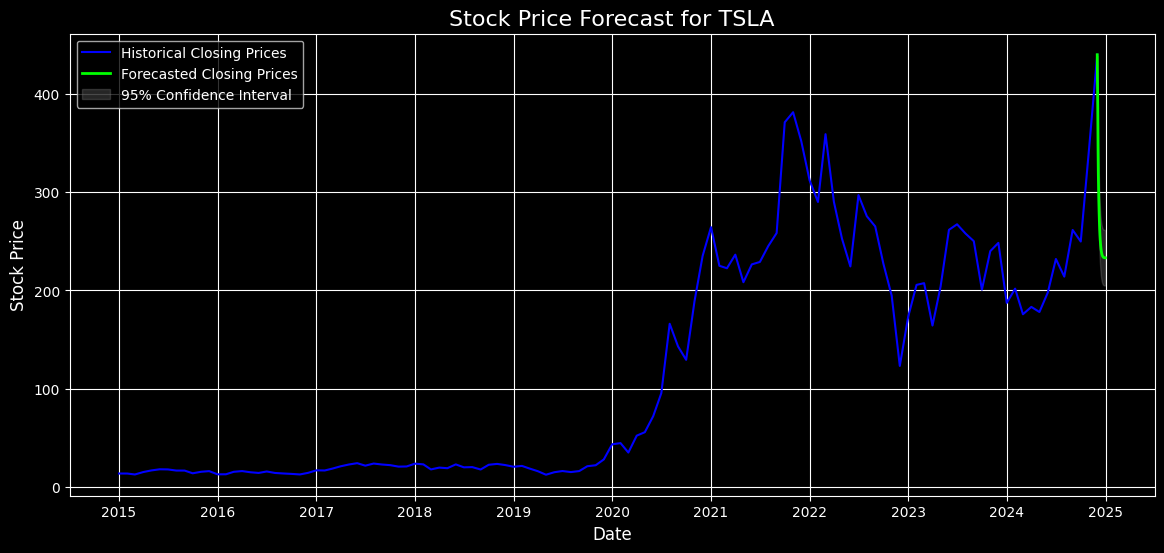

In [49]:
# Plot historical data and forecasted future data on the same chart
plt.figure(figsize=(14, 6))

# Plot the historical closing prices
plt.plot(df.index, df['Close'], label="Historical Closing Prices", color="blue")

# Plot the forecasted future closing prices as a line starting from the last historical point
plt.plot(
    [df.index[-1]] + list(future_dates),  # Combine last historical date with future dates
    [df['Close'].iloc[-1]] + list(future_predictions_close),  # Combine last historical price with future predictions
    label="Forecasted Closing Prices", color="lime", linewidth=2
)

# Add confidence interval shading for future predictions
plt.fill_between(
    future_dates,
    confidence_lower_future,
    confidence_upper_future,
    color='gray',
    alpha=0.3,
    label='95% Confidence Interval'
)

# Add title, labels, and legend
plt.title(f"Stock Price Forecast for {stock_symbol}", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price", fontsize=12)
plt.legend()

# Display grid and show the plot
plt.grid(True)
plt.savefig(f'{stock_symbol}_forecast.png')
plt.show()


Thank you for exploring this notebook!

You can find a more detailed tutorial an more of my work and updates on:

- [GitHub](https://github.com/Brianhulela)
- [Medium](https://medium.com/@brianhulela)